#**INSTALLING NECESSARY LIBRARIES**

In [ ]:
!pip install numpy==1.26.4 --force-reinstall


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [ ]:
!pip uninstall -y numpy


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install numpy==1.23.5 --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 54.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.34.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.0.

#**IMPORTING NECESSARY LIBRARIES**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import resampy
import os
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

#**MOUNTING THE DRIVE TO ACCESS THE DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**VARIOUS WINDOWING FUNCTION**

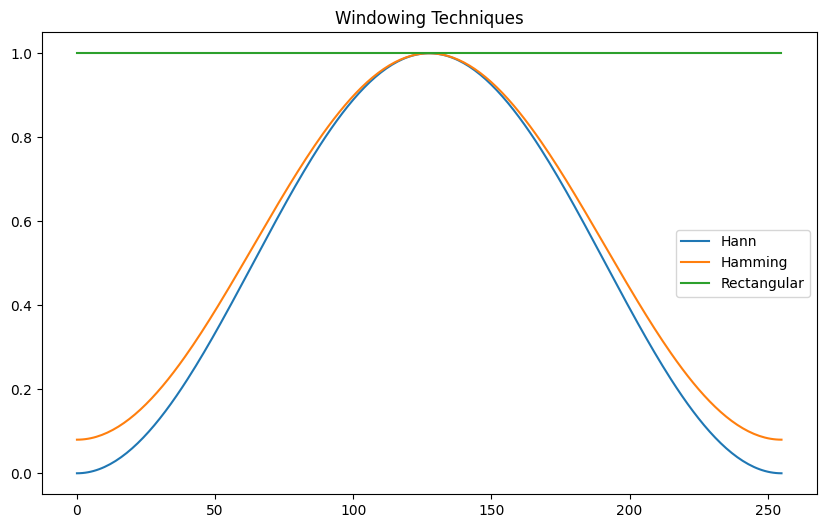

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

def hamming_window(N):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

def rectangular_window(N):
    return np.ones(N)

N = 256
windows = {"Hann": hann_window(N), "Hamming": hamming_window(N), "Rectangular": rectangular_window(N)}

plt.figure(figsize=(10, 6))
for name, win in windows.items():
    plt.plot(win, label=name)
plt.title("Windowing Techniques")
plt.legend()
plt.show()


#**Audio Signal Loading and Visualization**

In [ ]:
import librosa
import librosa.display

audio_path = "/content/drive/MyDrive/UrbanSound8K/audio/fold1/191431-9-0-61.wav"
y, sr = librosa.load(audio_path)

print(f"Audio duration: {librosa.get_duration(y=y, sr=sr)} seconds")


Audio duration: 4.0 seconds


#**Original audio with 1 channel**

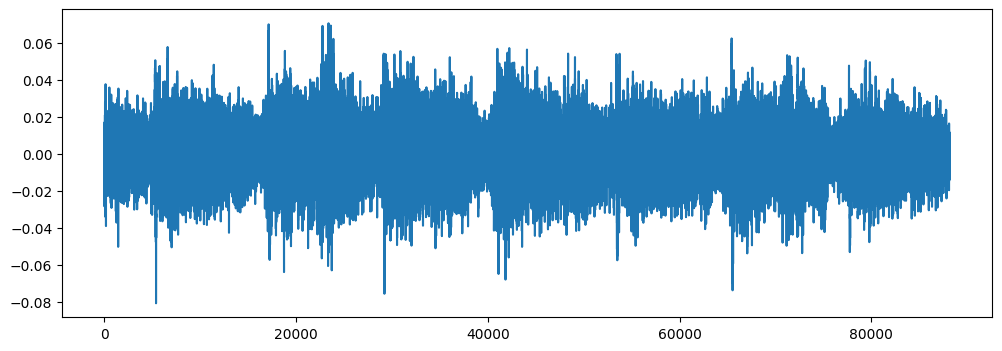

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.show()

In [ ]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_path)

#**Original audio with 2 channels**

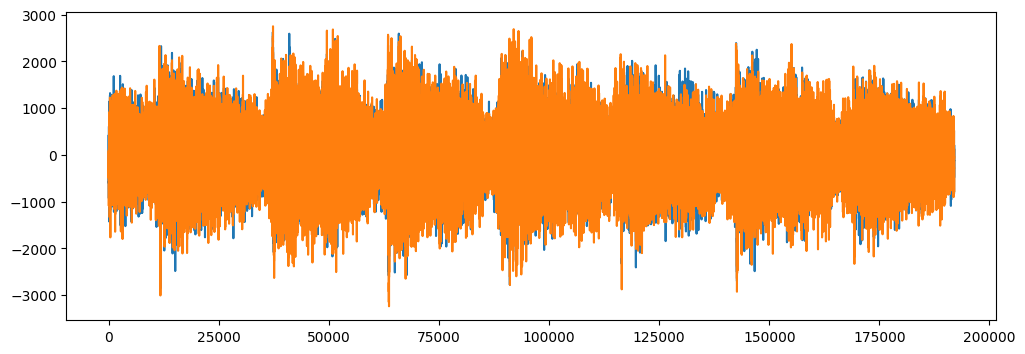

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)   #n_mfcc: number of MFCCs to return

print(mfccs.shape)

(40, 173)


In [ ]:
import pandas as pd
audio_dataset_path = "/content/drive/MyDrive/UrbanSound8K/audio"
metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#**Visual distribution of classes**

<ipython-input-10-31fadbcf6a94>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


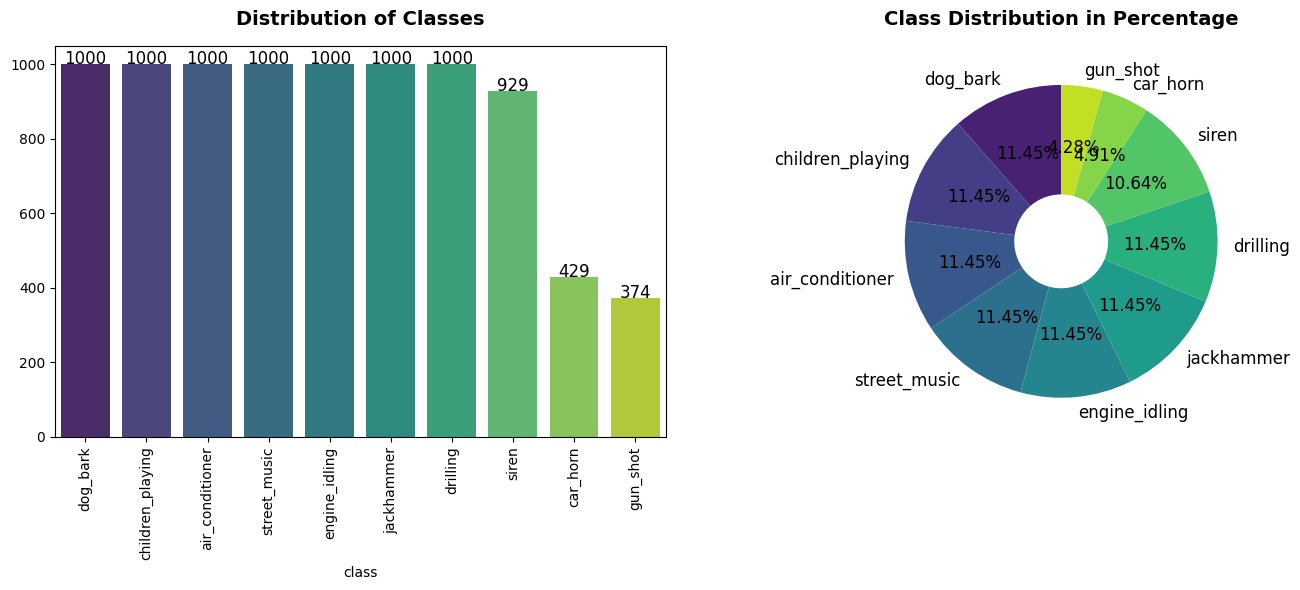

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
class_counts = metadata["class"].value_counts()

sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribution of Classes", fontweight="bold", size=14, pad=15)

for index, value in enumerate(class_counts.values):
    plt.text(index, value, str(value), ha="center", fontsize=12)

plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
colors = sns.color_palette("viridis", len(class_counts))
plt.pie(class_counts, labels=class_counts.index, autopct="%.2f%%",
        colors=colors, startangle=90, textprops={"fontsize": 12})

center_circle = plt.Circle((0, 0), 0.3, fc="white")
plt.gca().add_artist(center_circle)
plt.title("Class Distribution in Percentage", fontweight="bold", size=14, pad=15)

plt.tight_layout()
plt.show()

#**Mel-Frequency Cepstral Coefficients (MFCCs) of the audio signal**

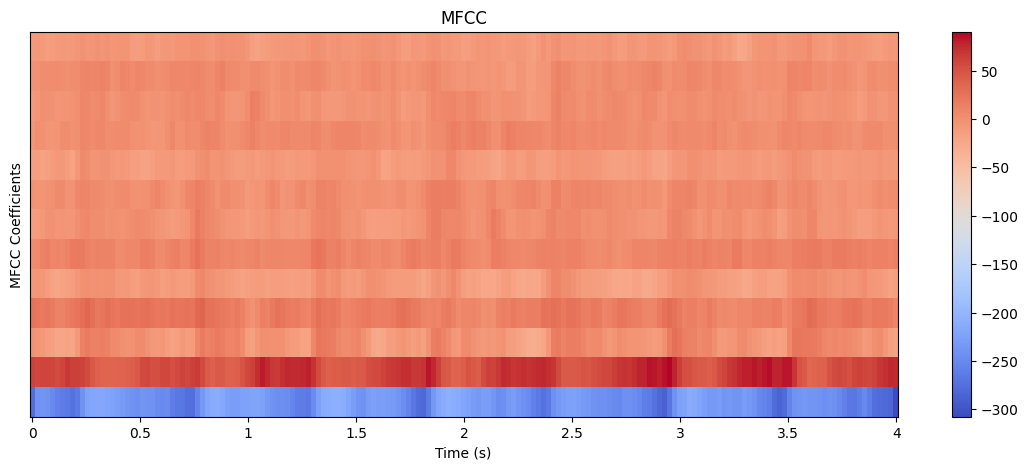

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df


,feature,class
0,"[[-333.38168, -172.86313, -94.09413, -60.86848...",dog_bark
1,"[[-489.11713, -451.05603, -445.70062, -440.020...",children_playing
2,"[[-494.69894, -468.22916, -476.6907, -482.8309...",children_playing
3,"[[-444.25037, -408.51923, -404.58514, -404.187...",children_playing
4,"[[-470.15686, -434.04797, -438.31635, -437.627...",children_playing
...,...,...
8727,"[[-426.88046, -399.10907, -402.37387, -403.812...",car_horn
8728,"[[-479.73572, -451.0463, -447.31027, -442.0757...",car_horn
8729,"[[-325.3323, -298.1148, -300.3505, -299.12598,...",car_horn
8730,"[[-400.48465, -366.7077, -362.00775, -360.2878...",car_horn


In [ ]:
for idx, feature in enumerate(extracted_features_df['feature'].head()):
    print(f"Index {idx}: Type: {type(feature)}, Shape: {np.shape(feature)}")

Index 0: Type: <class 'numpy.ndarray'>, Shape: (40, 14)
Index 1: Type: <class 'numpy.ndarray'>, Shape: (40, 173)
Index 2: Type: <class 'numpy.ndarray'>, Shape: (40, 173)
Index 3: Type: <class 'numpy.ndarray'>, Shape: (40, 173)
Index 4: Type: <class 'numpy.ndarray'>, Shape: (40, 173)


#**Spectogram of audio signal using various windowing techniques**

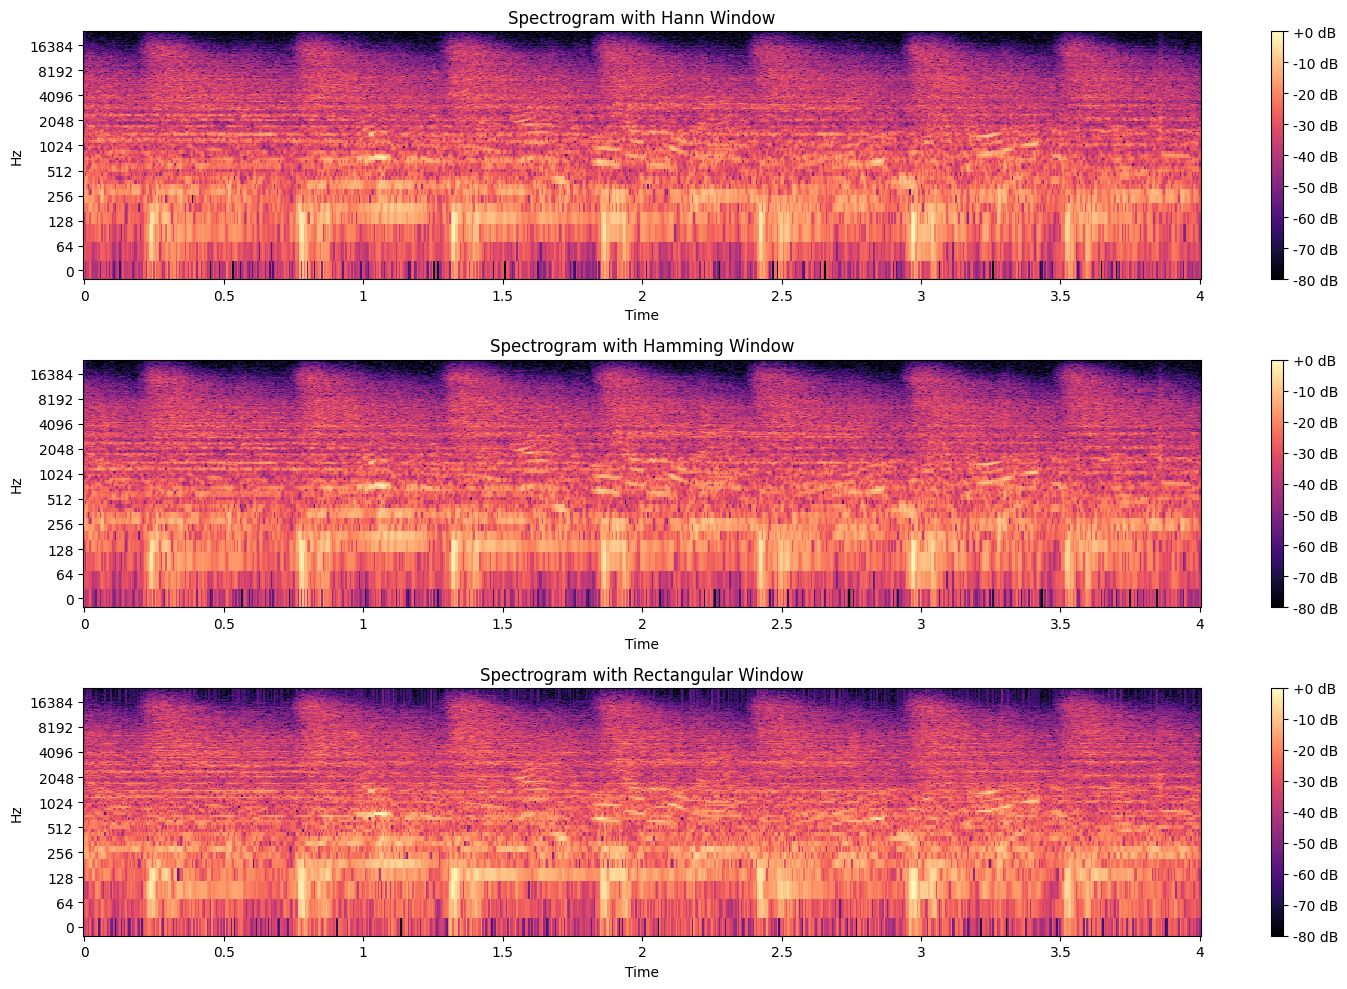

In [ ]:

def compute_stft(y, sr, window_func):
    N = 1024
    hop_length = N // 4
    window = window_func(N)
    stft = librosa.stft(y, n_fft=N, hop_length=hop_length, window=window)
    return librosa.amplitude_to_db(np.abs(stft), ref=np.max)

spectrograms = {
    "Hann": compute_stft(y, sr, hann_window),
    "Hamming": compute_stft(y, sr, hamming_window),
    "Rectangular": compute_stft(y, sr, rectangular_window),
}

plt.figure(figsize=(15, 10))
for i, (name, spec) in enumerate(spectrograms.items()):
    plt.subplot(3, 1, i + 1)
    librosa.display.specshow(spec, sr=sr, hop_length=256, x_axis="time", y_axis="log")
    plt.title(f"Spectrogram with {name} Window")
    plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


#**Audio Feature Extraction and Preprocessing for Classification**

In [ ]:

def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

def hamming_window(N):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

def rectangular_window(N):
    return np.ones(N)

def features_extractor(file_name, window_type='hann', target_length=173):
    audio, sr = librosa.load(file_name)
    try:
        audio = resampy.resample(audio, sr, 22050)
        sr = 22050
    except Exception as e:
        print(f"Error in resampling {file_name}: {e}")
        return None

    if window_type == 'hann':
        window = hann_window(len(audio))
    elif window_type == 'hamming':
        window = hamming_window(len(audio))
    elif window_type == 'rectangular':
        window = rectangular_window(len(audio))
    else:
        raise ValueError("Invalid window type. Choose 'hann', 'hamming', or 'rectangular'.")

    audio_windowed = audio * window

    mfccs = librosa.feature.mfcc(y=audio_windowed, sr=sr, n_mfcc=40)
    if mfccs.shape[1] < target_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, target_length - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :target_length]
    return mfccs

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout1 = nn.Dropout(0.3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout2 = nn.Dropout(0.3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout3 = nn.Dropout(0.3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout2(x)
        x = torch.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.dropout3(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


def train_and_evaluate(X_train, X_test, y_train, y_test, window_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    early_stopping_counter = 0
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    epochs = 15

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"best_model_{window_type}.pt")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 8:
                print("Early stopping triggered")
                break

        scheduler.step()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Accuracy Curves ({window_type} Window)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss Curves ({window_type} Window)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({window_type} Window)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return best_val_accuracy

if 'metadata' not in locals() or 'audio_dataset_path' not in locals():
    raise ValueError("Please define 'metadata' and 'audio_dataset_path' before running the main loop.")

window_types = ['hann', 'hamming', 'rectangular']
results = {}

for window_type in window_types:
    extracted_features = []
    for index_num, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
        file_name = os.path.join(audio_dataset_path, 'fold' + str(row["fold"]), str(row["slice_file_name"]))
        final_class_labels = row["class"]
        try:
            data = features_extractor(file_name, window_type=window_type)
            if data is not None:
                extracted_features.append([data, final_class_labels])
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    features = []
    labels = []
    for i, row in enumerate(extracted_features):
        f = row[0]
        if isinstance(f, np.ndarray) and f.shape[0] == 40:
            features.append(f)
            labels.append(row[1])

#**Using CNN for Classification**

 41%|████      | 3554/8732 [03:10<04:37, 18.67it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8323/8732 [07:28<00:13, 30.18it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8328/8732 [07:28<00:11, 35.33it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [07:50<00:00, 18.56it/s]


Using device: cpu


Epoch 1/15: 100%|██████████| 874/874 [02:12<00:00,  6.60it/s]


Epoch 1/15, Train Loss: 1.7589, Train Acc: 35.85%, Val Loss: 1.3844, Val Acc: 49.00%


Epoch 2/15: 100%|██████████| 874/874 [02:14<00:00,  6.48it/s]


Epoch 2/15, Train Loss: 1.2292, Train Acc: 56.55%, Val Loss: 1.0079, Val Acc: 66.57%


Epoch 3/15: 100%|██████████| 874/874 [02:16<00:00,  6.40it/s]


Epoch 3/15, Train Loss: 0.9217, Train Acc: 69.71%, Val Loss: 0.7674, Val Acc: 75.84%


Epoch 4/15: 100%|██████████| 874/874 [02:16<00:00,  6.41it/s]


Epoch 4/15, Train Loss: 0.7390, Train Acc: 76.03%, Val Loss: 0.6061, Val Acc: 80.82%


Epoch 5/15: 100%|██████████| 874/874 [02:15<00:00,  6.45it/s]


Epoch 5/15, Train Loss: 0.6596, Train Acc: 79.06%, Val Loss: 0.5185, Val Acc: 83.92%


Epoch 6/15: 100%|██████████| 874/874 [02:14<00:00,  6.50it/s]


Epoch 6/15, Train Loss: 0.4420, Train Acc: 85.34%, Val Loss: 0.4139, Val Acc: 87.06%


Epoch 7/15: 100%|██████████| 874/874 [02:16<00:00,  6.42it/s]


Epoch 7/15, Train Loss: 0.3930, Train Acc: 87.03%, Val Loss: 0.3907, Val Acc: 88.15%


Epoch 8/15: 100%|██████████| 874/874 [02:20<00:00,  6.23it/s]


Epoch 8/15, Train Loss: 0.3699, Train Acc: 87.59%, Val Loss: 0.3683, Val Acc: 88.95%


Epoch 9/15: 100%|██████████| 874/874 [02:13<00:00,  6.55it/s]


Epoch 9/15, Train Loss: 0.3391, Train Acc: 88.62%, Val Loss: 0.3526, Val Acc: 88.95%


Epoch 10/15: 100%|██████████| 874/874 [02:17<00:00,  6.34it/s]


Epoch 10/15, Train Loss: 0.3154, Train Acc: 89.32%, Val Loss: 0.3493, Val Acc: 89.12%


Epoch 11/15: 100%|██████████| 874/874 [02:13<00:00,  6.53it/s]


Epoch 11/15, Train Loss: 0.2874, Train Acc: 89.86%, Val Loss: 0.3321, Val Acc: 89.93%


Epoch 12/15: 100%|██████████| 874/874 [02:15<00:00,  6.44it/s]


Epoch 12/15, Train Loss: 0.2819, Train Acc: 90.44%, Val Loss: 0.3287, Val Acc: 90.04%


Epoch 13/15: 100%|██████████| 874/874 [02:13<00:00,  6.54it/s]


Epoch 13/15, Train Loss: 0.2801, Train Acc: 90.61%, Val Loss: 0.3271, Val Acc: 89.98%


Epoch 14/15: 100%|██████████| 874/874 [02:15<00:00,  6.46it/s]


Epoch 14/15, Train Loss: 0.2791, Train Acc: 90.55%, Val Loss: 0.3244, Val Acc: 89.75%


Epoch 15/15: 100%|██████████| 874/874 [02:13<00:00,  6.53it/s]


Epoch 15/15, Train Loss: 0.2793, Train Acc: 90.21%, Val Loss: 0.3259, Val Acc: 89.81%


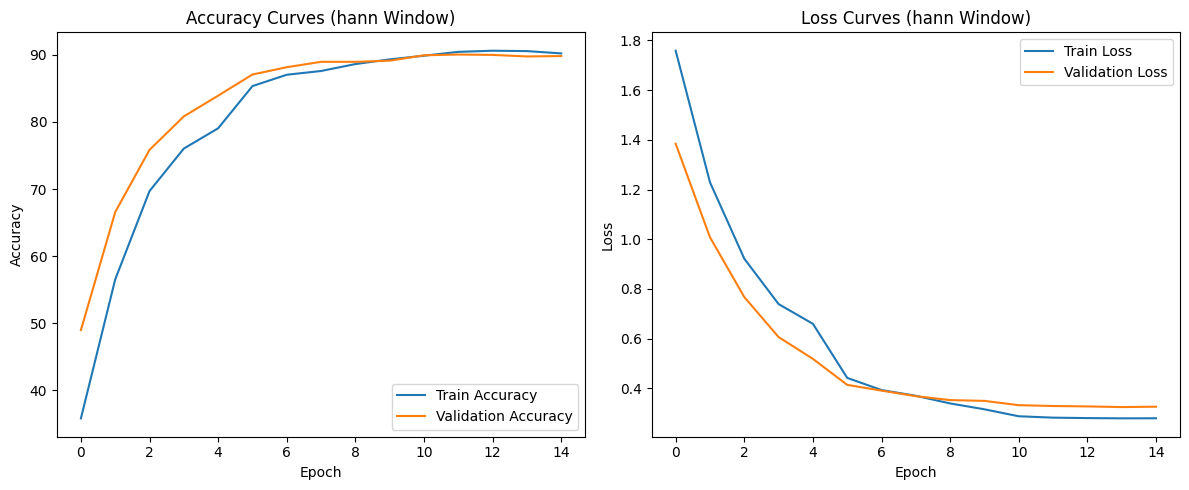

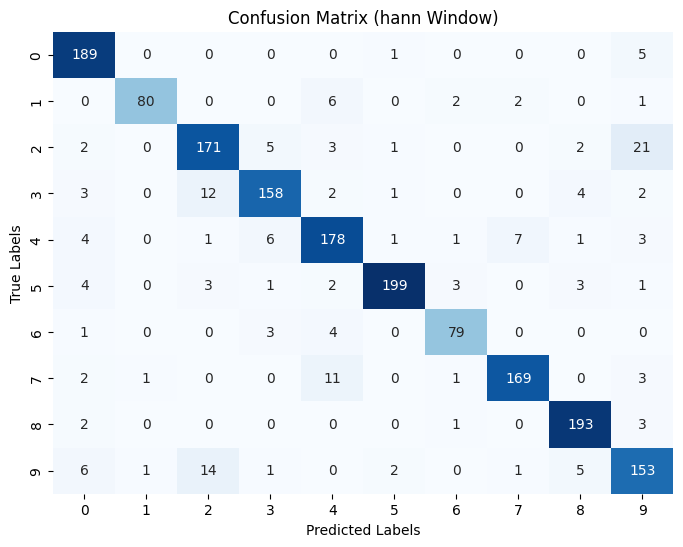

Validation Test Set Accuracy for hann window: 90.04006868918145


 41%|████      | 3553/8732 [03:25<04:07, 20.95it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8325/8732 [07:47<00:13, 30.87it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [08:07<00:00, 17.91it/s]


Using device: cpu


Epoch 1/15: 100%|██████████| 874/874 [02:19<00:00,  6.27it/s]


Epoch 1/15, Train Loss: 1.8537, Train Acc: 31.58%, Val Loss: 1.4735, Val Acc: 47.62%


Epoch 2/15: 100%|██████████| 874/874 [02:13<00:00,  6.55it/s]


Epoch 2/15, Train Loss: 1.3211, Train Acc: 52.93%, Val Loss: 1.0122, Val Acc: 68.52%


Epoch 3/15: 100%|██████████| 874/874 [02:15<00:00,  6.44it/s]


Epoch 3/15, Train Loss: 1.0347, Train Acc: 64.80%, Val Loss: 0.8861, Val Acc: 69.61%


Epoch 4/15: 100%|██████████| 874/874 [02:14<00:00,  6.48it/s]


Epoch 4/15, Train Loss: 0.8617, Train Acc: 70.98%, Val Loss: 0.7556, Val Acc: 75.79%


Epoch 5/15: 100%|██████████| 874/874 [02:16<00:00,  6.39it/s]


Epoch 5/15, Train Loss: 0.7795, Train Acc: 73.72%, Val Loss: 0.6850, Val Acc: 77.62%


Epoch 6/15: 100%|██████████| 874/874 [02:14<00:00,  6.49it/s]


Epoch 6/15, Train Loss: 0.5729, Train Acc: 80.76%, Val Loss: 0.5814, Val Acc: 81.51%


Epoch 7/15: 100%|██████████| 874/874 [02:17<00:00,  6.35it/s]


Epoch 7/15, Train Loss: 0.5249, Train Acc: 82.15%, Val Loss: 0.5516, Val Acc: 82.37%


Epoch 8/15: 100%|██████████| 874/874 [02:14<00:00,  6.49it/s]


Epoch 8/15, Train Loss: 0.4927, Train Acc: 83.01%, Val Loss: 0.5049, Val Acc: 84.26%


Epoch 9/15: 100%|██████████| 874/874 [02:16<00:00,  6.40it/s]


Epoch 9/15, Train Loss: 0.4658, Train Acc: 84.22%, Val Loss: 0.5035, Val Acc: 84.37%


Epoch 10/15: 100%|██████████| 874/874 [02:19<00:00,  6.29it/s]


Epoch 10/15, Train Loss: 0.4474, Train Acc: 84.77%, Val Loss: 0.4583, Val Acc: 85.52%


Epoch 11/15: 100%|██████████| 874/874 [02:16<00:00,  6.42it/s]


Epoch 11/15, Train Loss: 0.4221, Train Acc: 85.37%, Val Loss: 0.4563, Val Acc: 85.92%


Epoch 12/15: 100%|██████████| 874/874 [02:13<00:00,  6.54it/s]


Epoch 12/15, Train Loss: 0.4158, Train Acc: 85.73%, Val Loss: 0.4568, Val Acc: 85.80%


Epoch 13/15: 100%|██████████| 874/874 [02:15<00:00,  6.43it/s]


Epoch 13/15, Train Loss: 0.4031, Train Acc: 86.16%, Val Loss: 0.4469, Val Acc: 86.09%


Epoch 14/15: 100%|██████████| 874/874 [02:14<00:00,  6.50it/s]


Epoch 14/15, Train Loss: 0.4001, Train Acc: 86.31%, Val Loss: 0.4445, Val Acc: 86.43%


Epoch 15/15: 100%|██████████| 874/874 [02:15<00:00,  6.43it/s]


Epoch 15/15, Train Loss: 0.4062, Train Acc: 86.46%, Val Loss: 0.4356, Val Acc: 86.20%


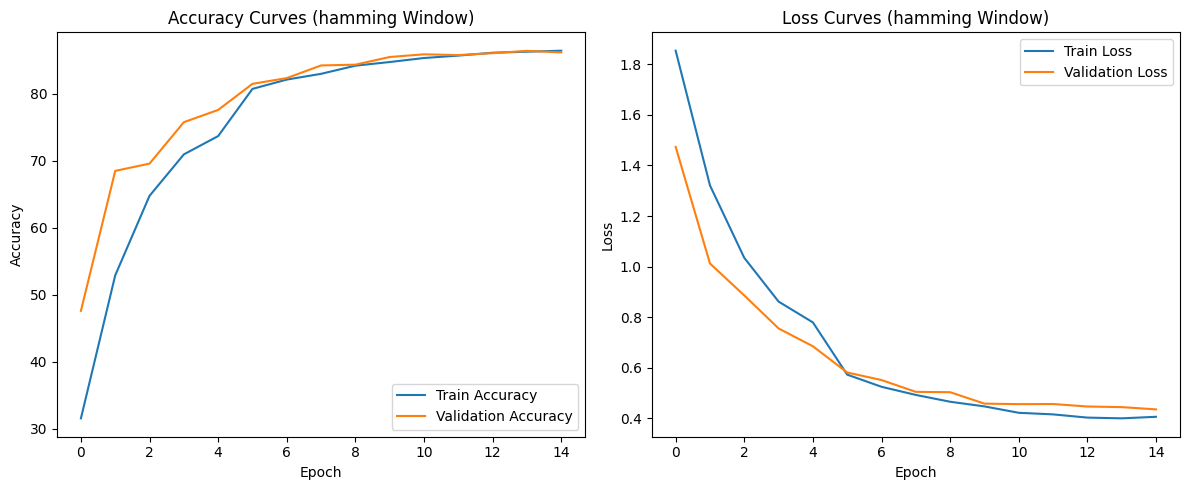

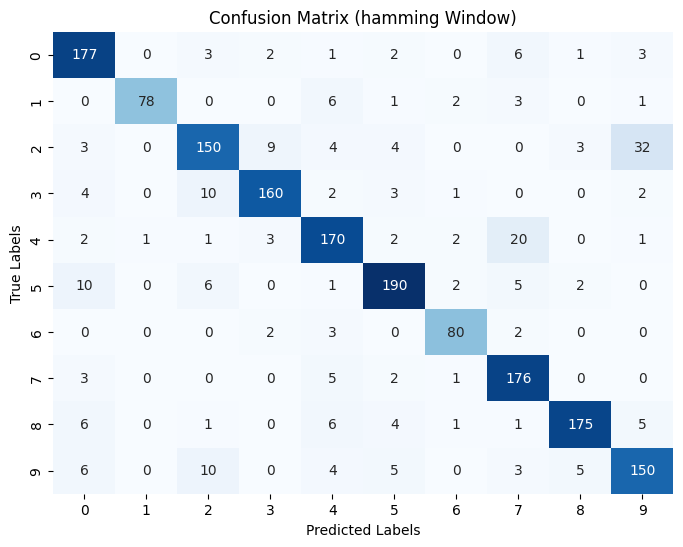

Validation Test Set Accuracy for hamming window: 86.4338866628506


 41%|████      | 3554/8732 [03:17<03:49, 22.58it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8325/8732 [07:22<00:12, 32.39it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [07:42<00:00, 18.89it/s]


Using device: cpu


Epoch 1/15: 100%|██████████| 874/874 [02:15<00:00,  6.47it/s]


Epoch 1/15, Train Loss: 1.7909, Train Acc: 34.12%, Val Loss: 1.4113, Val Acc: 53.46%


Epoch 2/15: 100%|██████████| 874/874 [02:19<00:00,  6.27it/s]


Epoch 2/15, Train Loss: 1.2357, Train Acc: 56.69%, Val Loss: 0.9460, Val Acc: 69.32%


Epoch 3/15: 100%|██████████| 874/874 [02:19<00:00,  6.26it/s]


Epoch 3/15, Train Loss: 0.9620, Train Acc: 67.86%, Val Loss: 0.8142, Val Acc: 74.41%


Epoch 4/15: 100%|██████████| 874/874 [02:18<00:00,  6.33it/s]


Epoch 4/15, Train Loss: 0.7889, Train Acc: 74.33%, Val Loss: 0.6704, Val Acc: 79.22%


Epoch 5/15: 100%|██████████| 874/874 [02:17<00:00,  6.35it/s]


Epoch 5/15, Train Loss: 0.7160, Train Acc: 76.82%, Val Loss: 0.5474, Val Acc: 82.31%


Epoch 6/15: 100%|██████████| 874/874 [02:21<00:00,  6.18it/s]


Epoch 6/15, Train Loss: 0.4900, Train Acc: 83.52%, Val Loss: 0.4699, Val Acc: 84.60%


Epoch 7/15: 100%|██████████| 874/874 [02:16<00:00,  6.38it/s]


Epoch 7/15, Train Loss: 0.4404, Train Acc: 85.58%, Val Loss: 0.4570, Val Acc: 85.06%


Epoch 8/15: 100%|██████████| 874/874 [02:17<00:00,  6.35it/s]


Epoch 8/15, Train Loss: 0.4057, Train Acc: 86.59%, Val Loss: 0.4116, Val Acc: 86.55%


Epoch 9/15: 100%|██████████| 874/874 [02:17<00:00,  6.38it/s]


Epoch 9/15, Train Loss: 0.3853, Train Acc: 87.19%, Val Loss: 0.4325, Val Acc: 86.72%


Epoch 10/15: 100%|██████████| 874/874 [02:17<00:00,  6.38it/s]


Epoch 10/15, Train Loss: 0.3618, Train Acc: 87.90%, Val Loss: 0.4292, Val Acc: 86.09%


Epoch 11/15: 100%|██████████| 874/874 [02:17<00:00,  6.35it/s]


Epoch 11/15, Train Loss: 0.3418, Train Acc: 88.26%, Val Loss: 0.3931, Val Acc: 87.64%


Epoch 12/15: 100%|██████████| 874/874 [02:18<00:00,  6.30it/s]


Epoch 12/15, Train Loss: 0.3403, Train Acc: 88.60%, Val Loss: 0.3849, Val Acc: 87.64%


Epoch 13/15: 100%|██████████| 874/874 [02:35<00:00,  5.63it/s]


Epoch 13/15, Train Loss: 0.3321, Train Acc: 88.92%, Val Loss: 0.3828, Val Acc: 87.98%


Epoch 14/15: 100%|██████████| 874/874 [02:35<00:00,  5.62it/s]


Epoch 14/15, Train Loss: 0.3297, Train Acc: 88.69%, Val Loss: 0.3839, Val Acc: 87.92%


Epoch 15/15: 100%|██████████| 874/874 [02:33<00:00,  5.69it/s]


Epoch 15/15, Train Loss: 0.3247, Train Acc: 88.83%, Val Loss: 0.3785, Val Acc: 88.09%


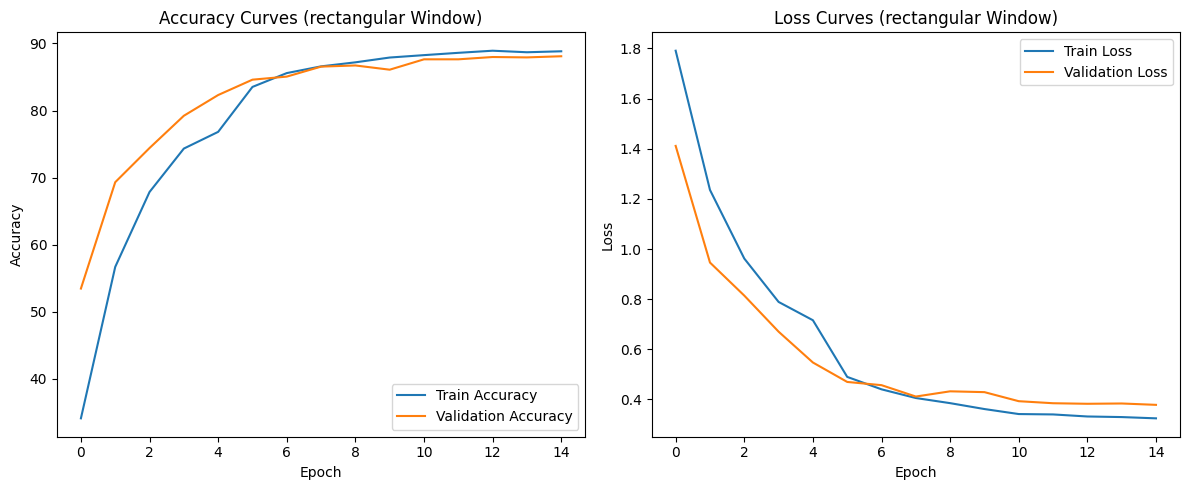

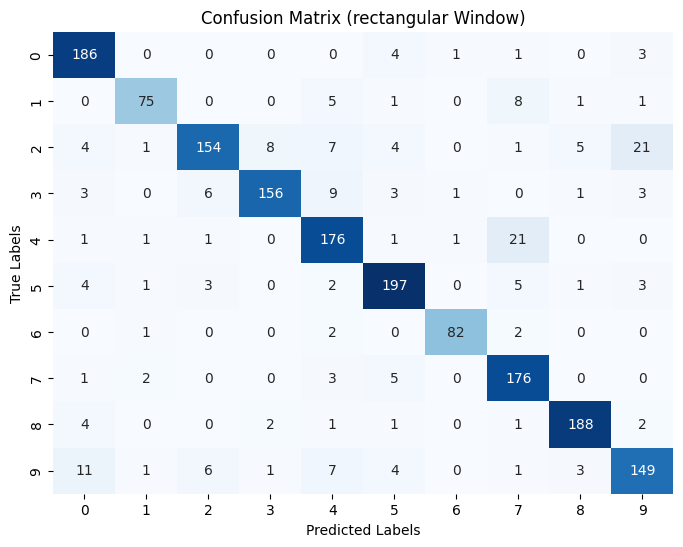

Validation Test Set Accuracy for rectangular window: 88.09387521465369
Comparison of results:
hann window: 90.04006868918145
hamming window: 86.4338866628506
rectangular window: 88.09387521465369


In [ ]:

    X = np.array(features)
    y = np.array(labels)

    labelencoder = LabelEncoder()
    y = labelencoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    X_train = X_train.reshape(X_train.shape[0], 1, 40, 173)
    X_test = X_test.reshape(X_test.shape[0], 1, 40, 173)

    accuracy = train_and_evaluate(X_train, X_test, y_train, y_test, window_type)
    results[window_type] = accuracy
    print(f"Validation Test Set Accuracy for {window_type} window: {accuracy}")

print("Comparison of results:")
for window_type, accuracy in results.items():
    print(f"{window_type} window: {accuracy}")